# Machine Learning for Predictive Analytics Mini Sprint
This notebook is documents the process of building a predictive model for the Machine Learning for Predictive Analytics Mini Sprint. We worked with a dataset from Bain & Company's HR department. The dataset contains information about employee attrition and our goal is to build a highly accurate model that can predict which employees are likely to leave the company, and to identify the key factors that influence attrition.

In [ ]:
# This variable is used to store the path to the data folder
data_path = '../data/predictive-analytics-sprint/'

The following lines Unzips the file that contains the data we will be analyzing for this project. This will typically only need to be done once locally, and ideally from here on out the notebook should be able to run a continuously without error.

In [ ]:
zip_file = 'data.zip'
!unzip -o {data_path + zip_file} -d {data_path}

In [116]:
# Here we import all our libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import graphviz
import seaborn as sns
import sklearn.tree as tree
from IPython.display import Image
from pandas.api import types 
from sklearn.preprocessing import MinMaxScaler, normalize
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, ConfusionMatrixDisplay
from sklearn.tree import DecisionTreeClassifier 
from xgboost import XGBClassifier, to_graphviz, plot_importance

## Cleaning and Preprocessing Data
The first step I took was to clean the data.I merged the employees general data, the employee survey data, and the manager survey data into one dataframe. I then checked for missing values and dropped any rows with missing values. I consider the possibility of engineering more features with the in time and out time data, but considering the volume of data we had it seems like overkill for this project.

In [117]:
# Load the data
general_data = pd.read_csv(data_path + 'general_data.csv')
# We swap the columns 'EmployeeID' and 'Age' to make the data more readable
cols = list(general_data.columns)
a, b = cols.index('EmployeeID'), cols.index('Age')
cols[b], cols[a] = cols[a], cols[b]
general_data = general_data[cols]

employee_survey_data = pd.read_csv(data_path + 'employee_survey_data.csv')
manager_survey_data = pd.read_csv(data_path + 'manager_survey_data.csv')

display(general_data.head() , employee_survey_data.head() , manager_survey_data.head())

,EmployeeID,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EmployeeCount,Age,Gender,...,NumCompaniesWorked,Over18,PercentSalaryHike,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager
0,1,No,Travel_Rarely,Sales,6,2,Life Sciences,1,51,Female,...,1.0,Y,11,8,0,1.0,6,1,0,0
1,2,Yes,Travel_Frequently,Research & Development,10,1,Life Sciences,1,31,Female,...,0.0,Y,23,8,1,6.0,3,5,1,4
2,3,No,Travel_Frequently,Research & Development,17,4,Other,1,32,Male,...,1.0,Y,15,8,3,5.0,2,5,0,3
3,4,No,Non-Travel,Research & Development,2,5,Life Sciences,1,38,Male,...,3.0,Y,11,8,3,13.0,5,8,7,5
4,5,No,Travel_Rarely,Research & Development,10,1,Medical,1,32,Male,...,4.0,Y,12,8,2,9.0,2,6,0,4


,EmployeeID,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance
0,1,3.0,4.0,2.0
1,2,3.0,2.0,4.0
2,3,2.0,2.0,1.0
3,4,4.0,4.0,3.0
4,5,4.0,1.0,3.0


,EmployeeID,JobInvolvement,PerformanceRating
0,1,3,3
1,2,2,4
2,3,3,3
3,4,2,3
4,5,3,3


In [118]:
# Here we merge all three data frames into oneon the employee column
data = pd.merge(general_data, employee_survey_data, on='EmployeeID')
data = pd.merge(data, manager_survey_data, on='EmployeeID')
# Drop rows with missing values
data.dropna(inplace=True)
data.isnull().sum()

EmployeeID                 0
Attrition                  0
BusinessTravel             0
Department                 0
DistanceFromHome           0
Education                  0
EducationField             0
EmployeeCount              0
Age                        0
Gender                     0
JobLevel                   0
JobRole                    0
MaritalStatus              0
MonthlyIncome              0
NumCompaniesWorked         0
Over18                     0
PercentSalaryHike          0
StandardHours              0
StockOptionLevel           0
TotalWorkingYears          0
TrainingTimesLastYear      0
YearsAtCompany             0
YearsSinceLastPromotion    0
YearsWithCurrManager       0
EnvironmentSatisfaction    0
JobSatisfaction            0
WorkLifeBalance            0
JobInvolvement             0
PerformanceRating          0
dtype: int64

I created separate copies for analysis and training since we will be applying different transformations to the data depending on what we are doing.

In [119]:
analysis_data = data.copy()
trainin_data = data.copy()

## Data Analysis 
I then performed some exploratory data analysis to understand the data better. I looked at the distribution of the target variable, the distribution of the features, and the correlation between the features and the target variable. I also looked at the correlation between the features to see if there are any multicollinearity issues. As you can see, we have a lot more cases of employees who stayed than those who left. In hindsight, I should have balanced the data before training the models.This may have led to a better recall rate for the decision tree model. A shout out to my team member Adkeme Berhe for providing the JMP analysis that highlights this imbalance.

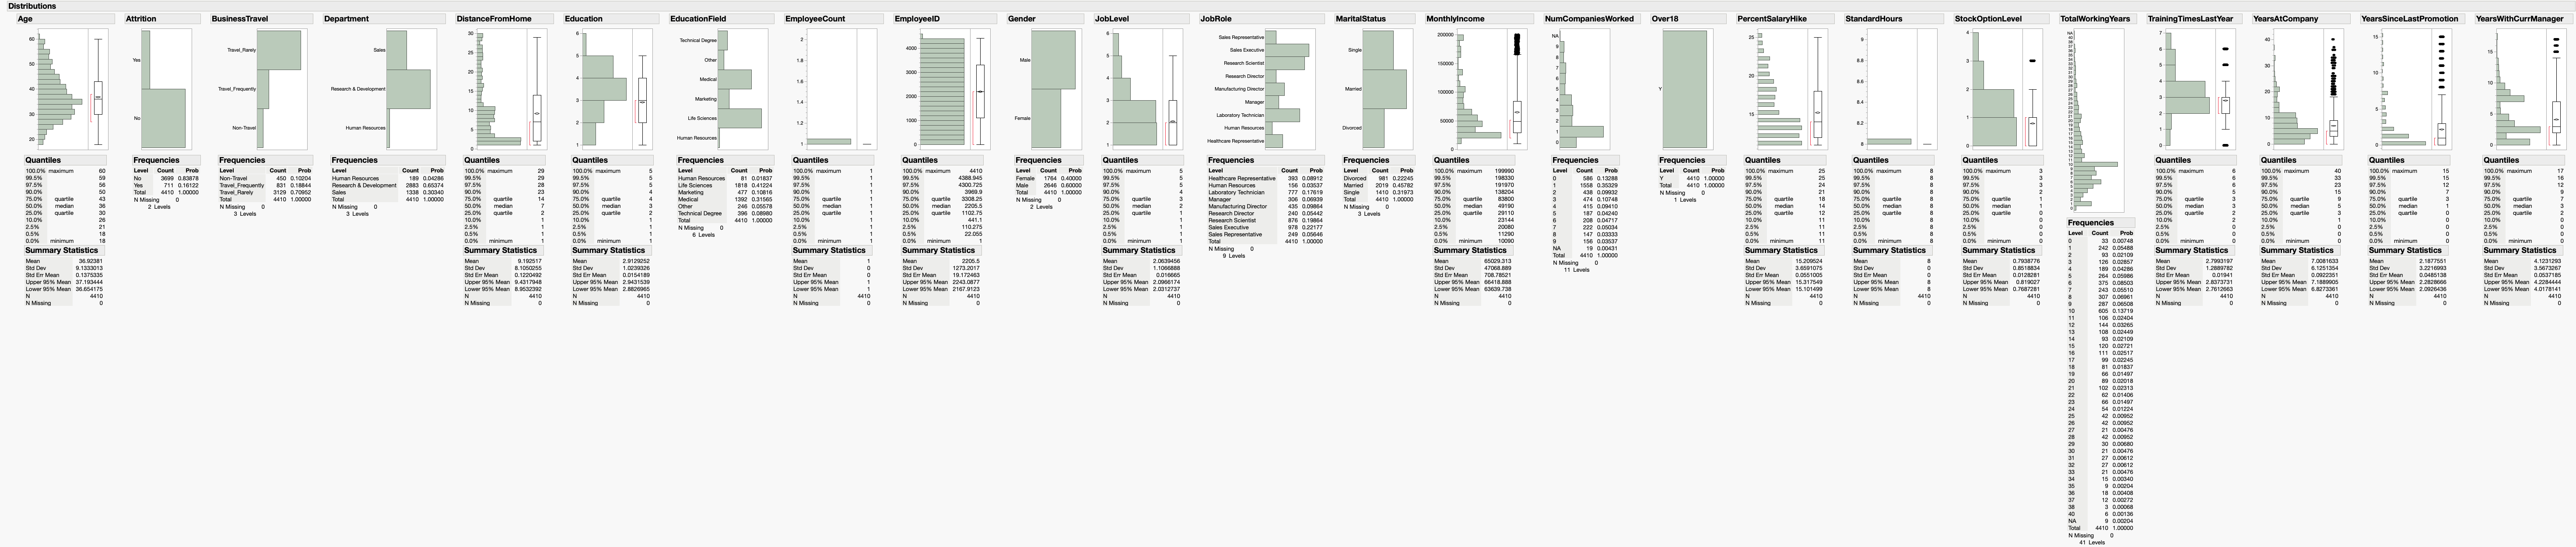

,EmployeeID,DistanceFromHome,Education,EmployeeCount,Age,JobLevel,MonthlyIncome,NumCompaniesWorked,PercentSalaryHike,StandardHours,...,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,JobInvolvement,PerformanceRating
count,4300.000000,4300.000000,4300.000000,4300.0,4300.000000,4300.000000,4300.000000,4300.000000,4300.000000,4300.0,...,4300.000000,4300.000000,4300.000000,4300.000000,4300.000000,4300.000000,4300.000000,4300.000000,4300.000000,4300.000000
mean,2211.695116,9.197907,2.913256,1.0,36.926977,2.066977,65059.844186,2.690000,15.210698,8.0,...,11.285116,2.796279,7.026047,2.190000,4.132558,2.723953,2.724884,2.761163,2.728837,3.153953
std,1272.117692,8.097059,1.024774,0.0,9.146517,1.106633,47045.398914,2.495764,3.662777,0.0,...,7.790052,1.290142,6.148036,3.230818,3.565831,1.093802,1.101875,0.707800,0.710769,0.360946
min,1.000000,1.000000,1.000000,1.0,18.000000,1.000000,10090.000000,0.000000,11.000000,8.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,3.000000
25%,1110.750000,2.000000,2.000000,1.0,30.000000,1.000000,29260.000000,1.000000,12.000000,8.0,...,6.000000,2.000000,3.000000,0.000000,2.000000,2.000000,2.000000,2.000000,2.000000,3.000000
50%,2215.500000,7.000000,3.000000,1.0,36.000000,2.000000,49360.000000,2.000000,14.000000,8.0,...,10.000000,3.000000,5.000000,1.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000
75%,3314.250000,14.000000,4.000000,1.0,43.000000,3.000000,83802.500000,4.000000,18.000000,8.0,...,15.000000,3.000000,9.250000,3.000000,7.000000,4.000000,4.000000,3.000000,3.000000,3.000000
max,4409.000000,29.000000,5.000000,1.0,60.000000,5.000000,199990.000000,9.000000,25.000000,8.0,...,40.000000,6.000000,40.000000,15.000000,17.000000,4.000000,4.000000,4.000000,4.000000,4.000000


In [120]:
data_description = 'data_description.png'
display(Image(data_path + data_description), analysis_data.describe())

In [121]:
# Loop through the columns and convert the non-numeric columns to numeric
for column in analysis_data.columns:
  # Check if the data type is not an integer or a float
  if not types.is_numeric_dtype(analysis_data[column]):
    # One hot encode the column with numerical categories
    analysis_data[column] = pd.Categorical(analysis_data[column])
    analysis_data[column] = analysis_data[column].cat.codes
analysis_data.head()

,EmployeeID,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EmployeeCount,Age,Gender,...,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,JobInvolvement,PerformanceRating
0,1,0,2,2,6,2,1,1,51,0,...,1.0,6,1,0,0,3.0,4.0,2.0,3,3
1,2,1,1,1,10,1,1,1,31,0,...,6.0,3,5,1,4,3.0,2.0,4.0,2,4
2,3,0,1,1,17,4,4,1,32,1,...,5.0,2,5,0,3,2.0,2.0,1.0,3,3
3,4,0,0,1,2,5,1,1,38,1,...,13.0,5,8,7,5,4.0,4.0,3.0,2,3
4,5,0,2,1,10,1,3,1,32,1,...,9.0,2,6,0,4,4.0,1.0,3.0,3,3


In [122]:
# Create a MinMaxScaler object
matrix_data = analysis_data.copy()
scaler = MinMaxScaler()
# Select the columns to normalize (excluding 'Attrition')
columns_to_normalize = analysis_data.columns[analysis_data.columns != 'Attrition']
# Normalize the selected columns
matrix_data[columns_to_normalize] = scaler.fit_transform(analysis_data[columns_to_normalize])
matrix_data.head()

,EmployeeID,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EmployeeCount,Age,Gender,...,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,JobInvolvement,PerformanceRating
0,0.000000,0,1.0,1.0,0.178571,0.25,0.2,0.0,0.785714,0.0,...,0.025,1.000000,0.025,0.000000,0.000000,0.666667,1.000000,0.333333,0.666667,0.0
1,0.000227,1,0.5,0.5,0.321429,0.00,0.2,0.0,0.309524,0.0,...,0.150,0.500000,0.125,0.066667,0.235294,0.666667,0.333333,1.000000,0.333333,1.0
2,0.000454,0,0.5,0.5,0.571429,0.75,0.8,0.0,0.333333,1.0,...,0.125,0.333333,0.125,0.000000,0.176471,0.333333,0.333333,0.000000,0.666667,0.0
3,0.000681,0,0.0,0.5,0.035714,1.00,0.2,0.0,0.476190,1.0,...,0.325,0.833333,0.200,0.466667,0.294118,1.000000,1.000000,0.666667,0.333333,0.0
4,0.000907,0,1.0,0.5,0.321429,0.00,0.6,0.0,0.333333,1.0,...,0.225,0.333333,0.150,0.000000,0.235294,1.000000,0.000000,0.666667,0.666667,0.0


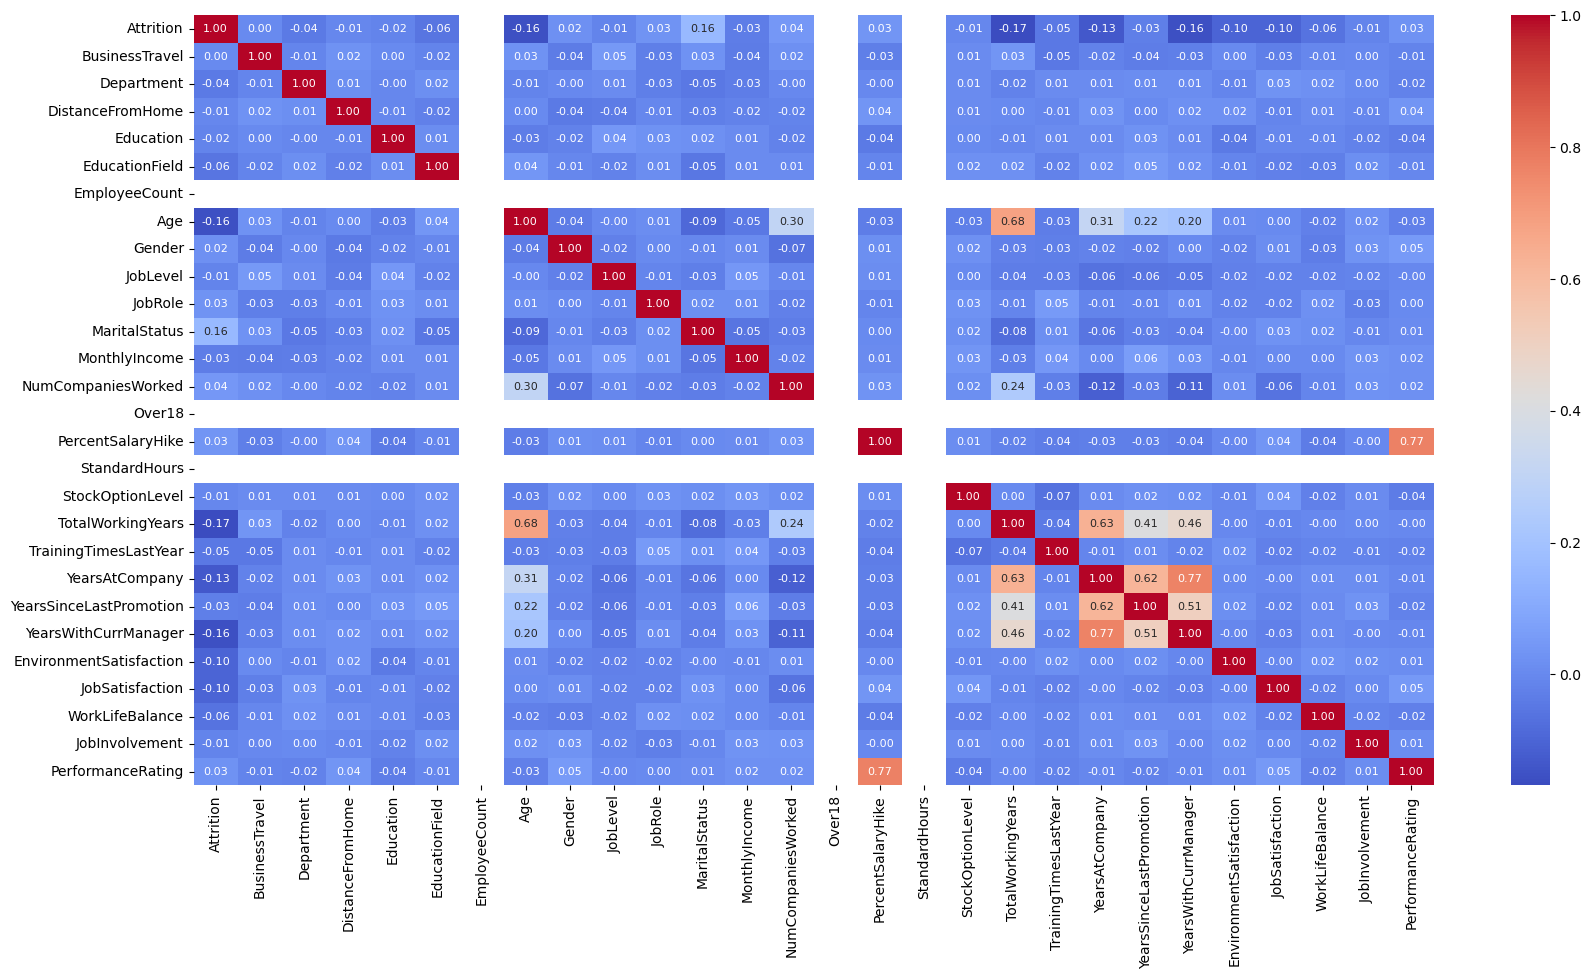

In [123]:
corr_matrix = matrix_data.drop(columns=['EmployeeID']).corr()
plt.figure(figsize=(20, 10))

# Plot correlation matrix
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', annot_kws={'size': 8})

plt.subplots_adjust(hspace=0.5)
plt.show()

[Text(0, 0, 'No'), Text(0, 1, 'Yes')]

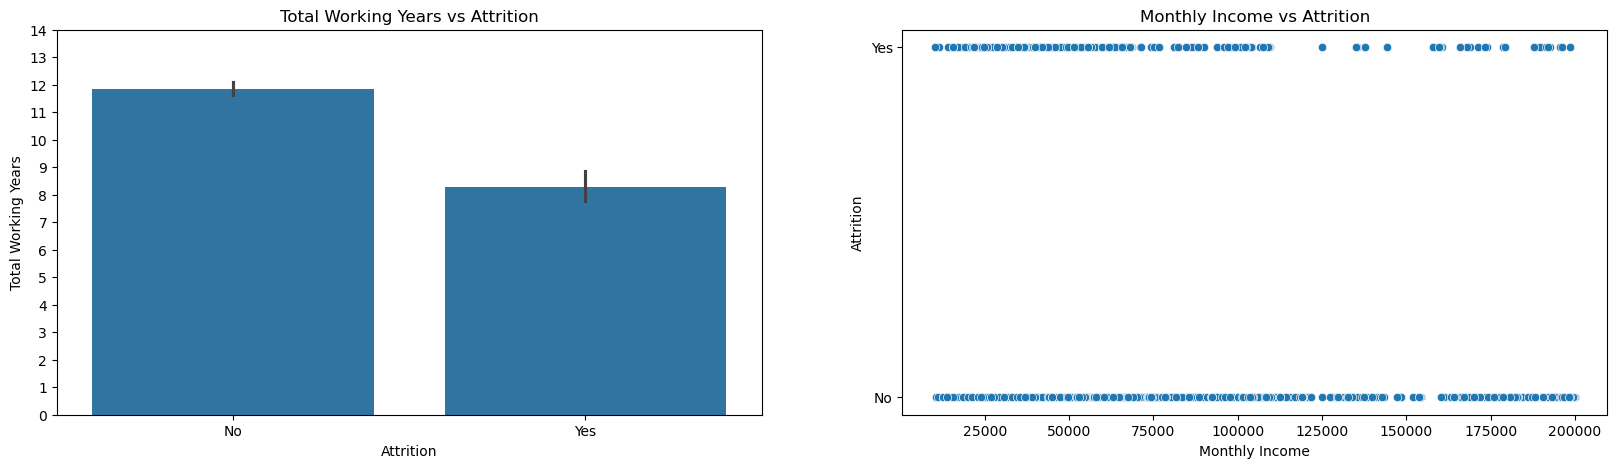

In [124]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))

sns.barplot(data=analysis_data, y='TotalWorkingYears', x='Attrition', ax=ax1)
ax1.set_title('Total Working Years vs Attrition')
ax1.set_xlabel('Attrition')
ax1.set_ylabel('Total Working Years')
ax1.set_yticks(range(0, 15))
ax1.set_xticks(range(0, 2, 1))
ax1.set_xticklabels(['No', 'Yes'])

sns.scatterplot(data=analysis_data, y='Attrition', x='MonthlyIncome', ax=ax2)
ax2.set_title('Monthly Income vs Attrition')
ax2.set_xlabel('Monthly Income')
ax2.set_ylabel('Attrition')
ax2.set_yticks(range(0, 2, 1))
ax2.set_yticklabels(['No', 'Yes'])

## Feature Selection and Engineering
Based on the correlation matrix, we can see that the following features have no correlation with the target variable Attrition and can be dropped from the training dataset:
- EmployeeCount
- Over18
- StandardHours

We will also drop EmloyeeID as it is not relevant to the analysis. On the basis of collinearity, I also eliminated Age, YearsAtCompany, YearsWithCurrManager, and PercentSalaryHike. The correlation matrix shows they were all highly correlated with existing features. Finally, we will also drop the features MaritalStatus, and Gender as we want to avoid any potential discriminatory biases in the model:

In [125]:
drop_columns = ['EmployeeID', 'EmployeeCount', 'StandardHours', 'MaritalStatus', 'Age', 'Over18', 'Gender', 'YearsAtCompany', 'PercentSalaryHike', 'YearsWithCurrManager']
trainin_data = trainin_data.drop(columns=drop_columns)

Here we will also encode the categorical variables using one-hot encoding or label encoding. We will experiment with both methods to see which one works best for our dataset.In the end after doing some research,I decided to use one hot encoding as it is more suitable for training decision tree models. Label encoding can potentially lead the model to assume an ordinal relationship between the categories.

In [126]:
# Identify categorical features (modify as needed)
categorical_features = ['BusinessTravel', 'Department', 'EducationField', 'JobRole']
# One-hot encode the specified features
trainin_data = pd.get_dummies(trainin_data, columns=categorical_features)
trainin_data['Attrition'] = trainin_data['Attrition'].map({'Yes': 1, 'No': 0})

In [ ]:
# Loop through the columns and convert the non-numeric columns to numeric
for column in trainin_data.columns:
  # Check if the data type is not an integer or a float
  if not types.is_numeric_dtype(trainin_data[column]):
    # One hot encode the column with numerical categories
    trainin_data[column] = pd.Categorical(trainin_data[column])
    trainin_data[column] = trainin_data[column].cat.codes

In [127]:
# Split the data into training,testing and validation sets
x_data = trainin_data.drop('Attrition', axis=1)
y_data = trainin_data['Attrition']
train_x, test_x, train_y, test_y = train_test_split(x_data, y_data, test_size=0.2, random_state=42)
# Display shapes of the data
display(trainin_data.head(), train_x.shape, test_x.shape, train_y.shape, test_y.shape)

,Attrition,DistanceFromHome,Education,JobLevel,MonthlyIncome,NumCompaniesWorked,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,YearsSinceLastPromotion,...,EducationField_Technical Degree,JobRole_Healthcare Representative,JobRole_Human Resources,JobRole_Laboratory Technician,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative
0,0,6,2,1,131160,1.0,0,1.0,6,0,...,False,True,False,False,False,False,False,False,False,False
1,1,10,1,1,41890,0.0,1,6.0,3,1,...,False,False,False,False,False,False,False,True,False,False
2,0,17,4,4,193280,1.0,3,5.0,2,0,...,False,False,False,False,False,False,False,False,True,False
3,0,2,5,3,83210,3.0,3,13.0,5,7,...,False,False,True,False,False,False,False,False,False,False
4,0,10,1,1,23420,4.0,2,9.0,2,0,...,False,False,False,False,False,False,False,False,True,False


(3440, 35)

(860, 35)

(3440,)

(860,)

## Model Setup
### Decision Tree Models vs. Logistic Regression
Based on our analysis, we will set up a model to predict employee attrition. We needed to decide between a logistic regression model or decision trees. After doing some research, we decided to use decision trees because they are more interpretable and can help us identify the key factors that influence attrition. We decided to build two models: One being a decision tree and the other being a gradient boosted forest. The reasoning for this is we believe while the gradient boosted forest will be more accurate, the decision tree will be more interpretable and will help us identify the key factors that influence attrition. This will benefit us in terms of explainability When presenting our findings to the HR lead, Kim.

### Understanding Model Execution
We will train the models on the training data and evaluate their performance on the test data. We will use the following metrics to evaluate the models: 
- **Accuracy**: The proportion of correctly classified instances. 
- **Precision**: The proportion of true positive instances among the instances that are predicted as positive.
- **Recall**: The proportion of true positive instances that are correctly predicted as positive.
- **F1 score**: The harmonic mean of precision and recall. 

There are several hyper parameters to be considered when training the models. We will use grid search to find the best hyper parameters for the models. We will also use cross-validation to ensure that the models are not overfitting the training data.

In [128]:
# Create a DecisionTreeClassifier object
param_grid = {
    'max_depth': [3, 5, 7],
    'min_samples_split': [5, 10, 15],
    'ccp_alpha': [0, 0.01, 0.02]
}
kfold = KFold(n_splits=10, random_state=42, shuffle=True)
grid_search = GridSearchCV(estimator=DecisionTreeClassifier(), param_grid=param_grid, cv=kfold, scoring='accuracy') 
grid_search.fit(train_x, train_y)

decision_tree_params = grid_search.best_params_
print(f'Best parameters: {decision_tree_params}')
print(f'Best score: {grid_search.best_score_}')
decision_tree = DecisionTreeClassifier(**decision_tree_params)

Best parameters: {'ccp_alpha': 0, 'max_depth': 7, 'min_samples_split': 5}
Best score: 0.8703488372093023


In [146]:
# Cross validation for the decision tree model
results = cross_val_score(decision_tree, train_x, train_y, cv=kfold)
print(results)
print(f'Cross-validation results: {results.mean()}')

[0.875      0.84302326 0.9127907  0.86337209 0.86046512 0.85174419
 0.86337209 0.88662791 0.85755814 0.88372093]
Cross-validation results: 0.8697674418604651


In [144]:
best_params = {
    'colsample_bytree': 1.0, 
    'eta': 0.1, 
    'gamma': 0.2, 
    'learning_rate': 0.5, 
    'max_depth': 5, 
    'min_child_weight': 2, 
    'n_estimators': 100, 
    'objective':  'binary:logistic', 
    'reg_alpha': 0, 
    'reg_lambda': 0, 
    'subsample': 0.8
}
xgb_model = XGBClassifier(**best_params)

**Note**: The code below Takes a substantial amount of time to run. I have included the results of the models in the markdown cells below the code cells. Roughly 15 hours on my machine, so I would recommend running the code in a cloud environment or on a machine that can run for a long period of time.

In [82]:
param_grid = {
    'n_estimators': [100, 500, 1000],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.1, 0.3, 0.5],
    'min_child_weight': [1, 2, 3],
    'gamma': [0, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'reg_alpha': [0, 0.1, 0.2],
    'reg_lambda': [0, 0.1, 0.2],
    'eta': [0.1, 0.2, 0.3],
    'objective': ['binary:logistic']
}
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, n_jobs=-1, cv=kfold, scoring='accuracy')
grid_search.fit(train_x, train_y)

print(f'Best parameters: {grid_search.best_params_}')
print(f'Best accuracy: {grid_search.best_score_}')
best_params = grid_search.best_params_

Best parameters: {'colsample_bytree': 1.0, 'eta': 0.1, 'gamma': 0.2, 'learning_rate': 0.5, 'max_depth': 5, 'min_child_weight': 2, 'n_estimators': 100, 'objective': 'binary:logistic', 'reg_alpha': 0, 'reg_lambda': 0, 'subsample': 0.8}
Best accuracy: 0.9886627906976744


- Best parameters: {'colsample_bytree': 1.0, 'eta': 0.1, 'gamma': 0.2, 'learning_rate': 0.5, 'max_depth': 5, 'min_child_weight': 2, 'n_estimators': 100, 'objective': 'binary:logistic', 'reg_alpha': 0, 'reg_lambda': 0, 'subsample': 0.8}
- Best accuracy: 0.9886627906976744

In [143]:
# Cross validation for the best XGBoost model
kfold = KFold(n_splits=10, random_state=42, shuffle=True)
best_xgb_model = XGBClassifier(**best_params)
results = cross_val_score(best_xgb_model, train_x, train_y, cv=kfold)

print(results)
print(f'Cross Validation Accuracy: {results.mean()*100:.2f}% ({results.std()*100:.2f}%)')

[0.99127907 0.99127907 0.99709302 0.97674419 0.97383721 0.97965116
 0.98255814 0.95930233 0.96802326 0.99418605]
Cross Validation Accuracy: 98.14% (1.16%)


## Model Training and Evaluation
Very straightforward code here to train and evaluate our models.

In [131]:
decision_tree.fit(train_x, train_y)

DecisionTreeClassifier(ccp_alpha=0, max_depth=7, min_samples_split=5)

In [132]:
best_xgb_model.fit(train_x, train_y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=1.0, early_stopping_rounds=None,
              enable_categorical=False, eta=0.1, eval_metric=None,
              feature_types=None, gamma=0.2, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.5, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=2, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, predictor=None, ...)

In [133]:
decision_tree_accuracy = decision_tree.score(test_x, test_y)
decision_tree_precision = precision_score(test_y, decision_tree.predict(test_x))
decision_tree_recall = recall_score(test_y, decision_tree.predict(test_x))
decision_tree_f1 = f1_score(test_y, decision_tree.predict(test_x))

xgb_accuracy = best_xgb_model.score(test_x, test_y)
xgb_precision = precision_score(test_y, best_xgb_model.predict(test_x))
xgb_recall = recall_score(test_y, best_xgb_model.predict(test_x))
xgb_f1 = f1_score(test_y, best_xgb_model.predict(test_x))

print(f'Decision Tree Classifier Accuracy: {decision_tree_accuracy}')
print(f'Decision Tree Classifier Precision: {decision_tree_precision}')
print(f'Decision Tree Classifier Recall: {decision_tree_recall}')
print(f'Decision Tree Classifier F1 Score: {decision_tree_f1}')

print(f'XGBoost Classifier Accuracy: {xgb_accuracy}')
print(f'XGBoost Classifier Precision: {xgb_precision}')
print(f'XGBoost Classifier Recall: {xgb_recall}')
print(f'XGBoost Classifier F1 Score: {xgb_f1}')



Decision Tree Classifier Accuracy: 0.8686046511627907
Decision Tree Classifier Precision: 0.7777777777777778
Decision Tree Classifier Recall: 0.2937062937062937
Decision Tree Classifier F1 Score: 0.4263959390862945
XGBoost Classifier Accuracy: 0.9965116279069768
XGBoost Classifier Precision: 1.0
XGBoost Classifier Recall: 0.9790209790209791
XGBoost Classifier F1 Score: 0.989399293286219


## Visualizations and Insights

Based on our evaluation results we can conclude the following:
- **Accuracy**: The gradient boosted forest model has a higher accuracy than the decision tree model. This means that the gradient boosted forest model is better at correctly classifying instances.
- **Precision**: The gradient boosted forest model has a higher precision than the decision tree model. This means that the gradient boosted forest model is better at not falsely classifying someone as likely to leave the company.
- **Recall**: The gradient boosted forest model has a higher recall than the decision tree model. This means that the gradient boosted forest model is better at identifying all employees who are likely to leave the company.
- **F1 Score**: The gradient boosted forest model has a higher F1 score than the decision tree model. This means that the gradient boosted forest model is better overall at predicting employee attrition.

Below we have visualizations of our findings for explainability. These were very helpful for crafting my final presentation for the HR lead, Kim.

<Axes: title={'center': 'Model Performance Comparison'}, xlabel='Metric', ylabel='Score'>

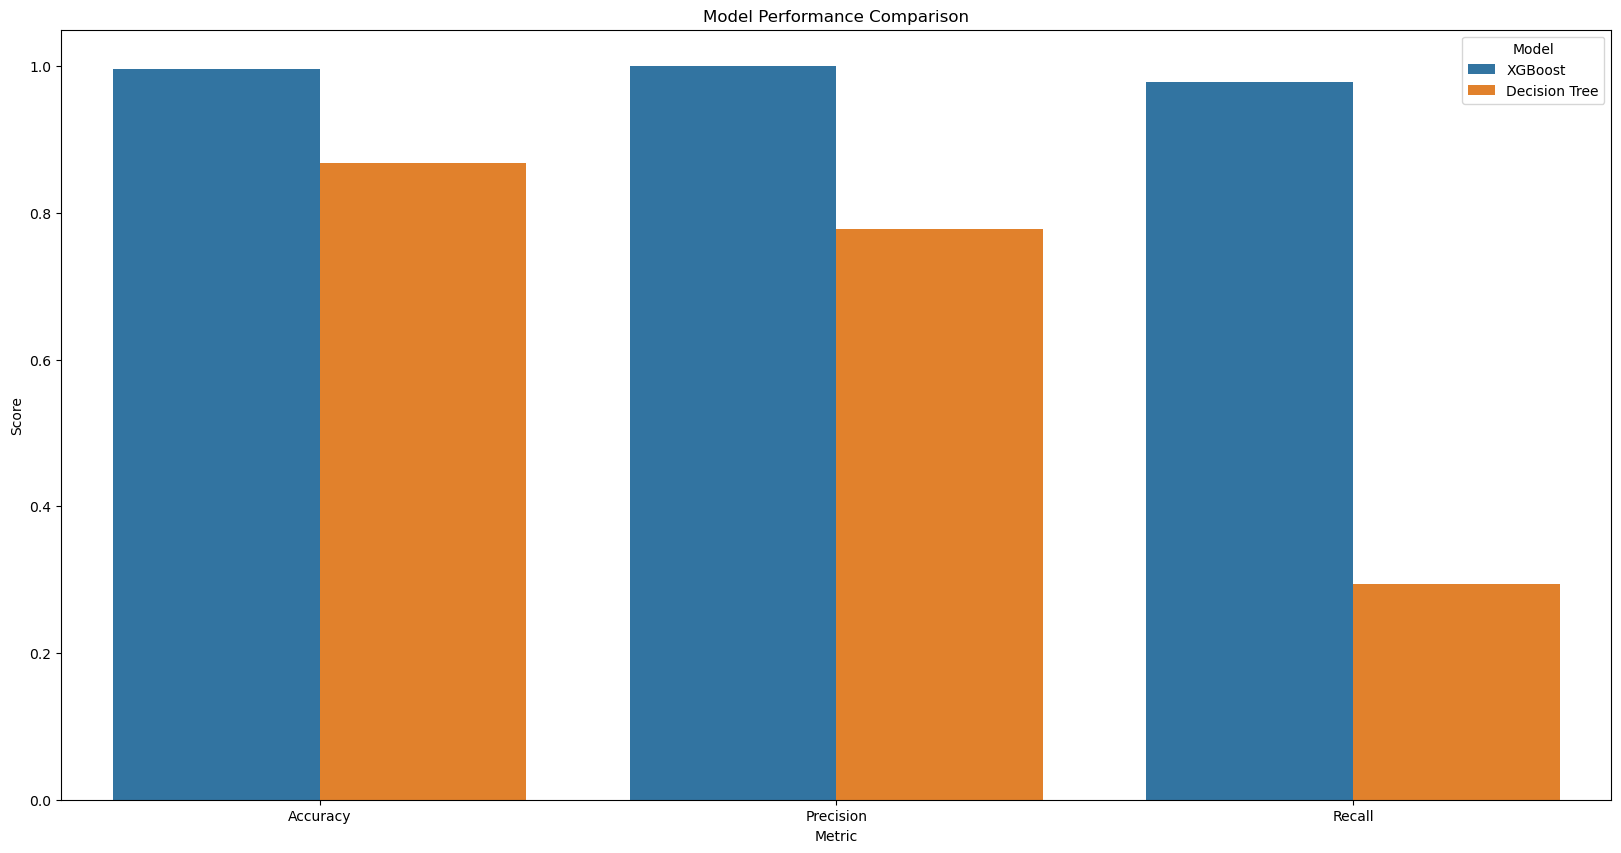

In [134]:
# Create a bar plot of both models' accuracy, precision, and recall

# Data
metrics = ['Accuracy', 'Precision', 'Recall']
accuracy = [xgb_accuracy, decision_tree_accuracy]
precision = [xgb_precision, decision_tree_precision]
recall = [xgb_recall, decision_tree_recall]

# Create a DataFrame
data = pd.DataFrame({'Metric': metrics, 'XGBoost': [xgb_accuracy, xgb_precision, xgb_recall], 'Decision Tree': [decision_tree_accuracy, decision_tree_precision, decision_tree_recall]})

# Melt the DataFrame
data_melted = data.melt('Metric', var_name='Model', value_name='Score')

plt.figure(figsize=(20, 10))

# Set the title and labels
plt.title('Model Performance Comparison')
plt.xlabel('Metric')
plt.ylabel('Score')

# Create the barplot
sns.barplot(x='Metric', y='Score', hue='Model', data=data_melted)


[[1.         0.        ]
 [0.02097902 0.97902098]]
[[0.9832636  0.0167364 ]
 [0.70629371 0.29370629]]


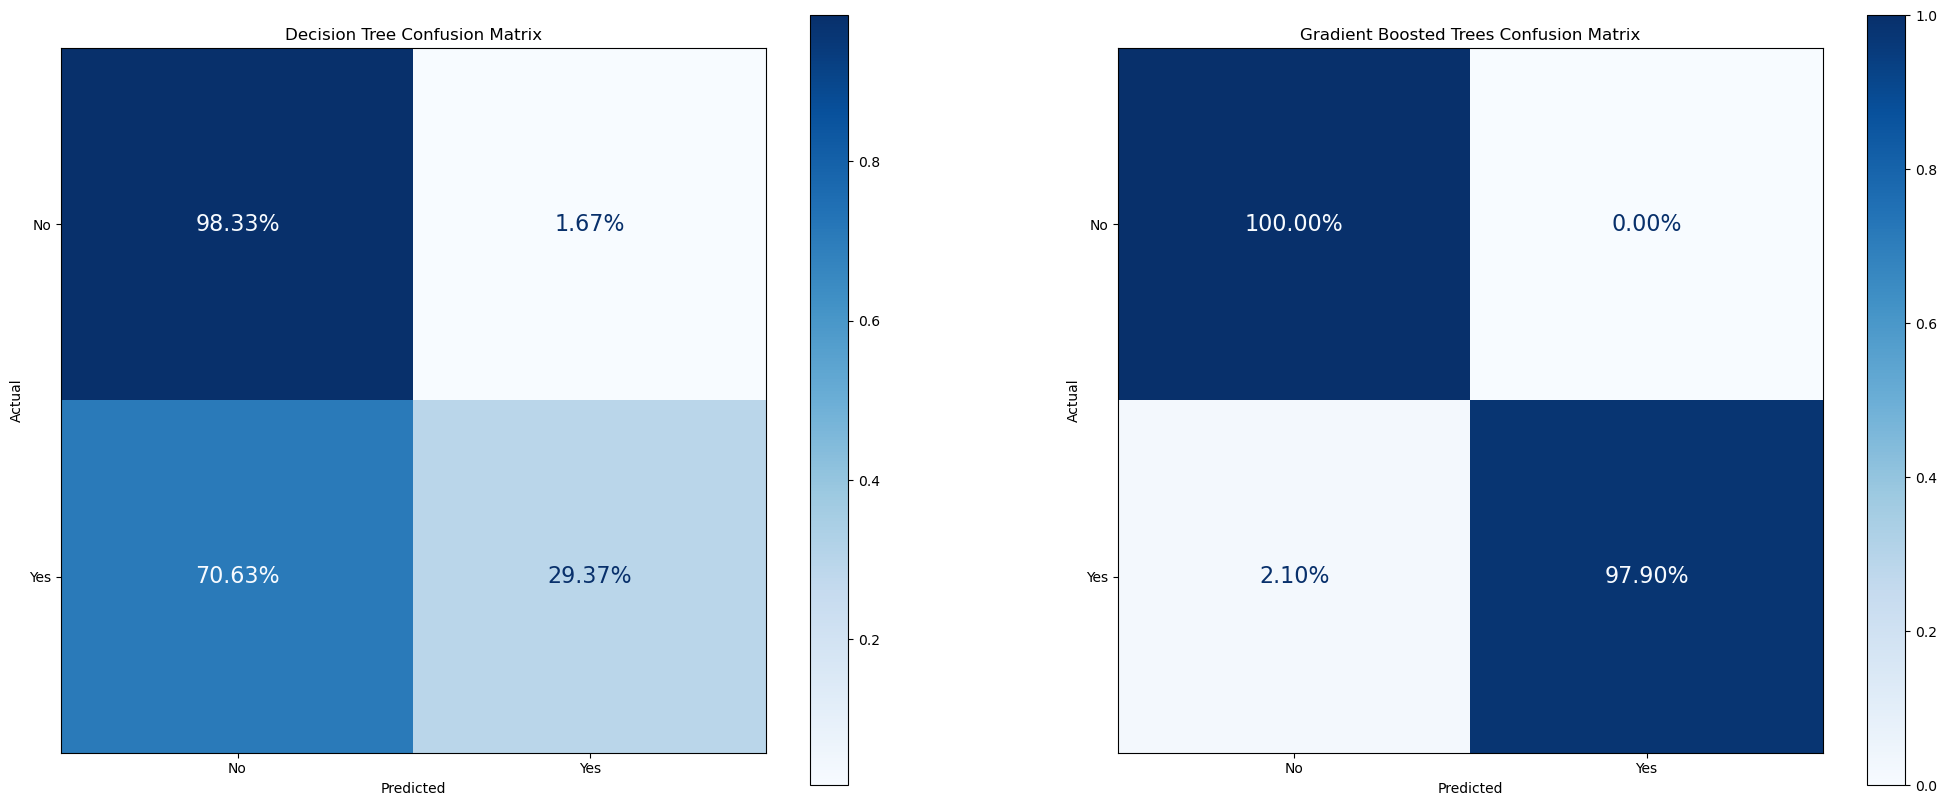

In [135]:
# Make predictions using the decision tree model
decision_tree_predictions = decision_tree.predict(test_x)
decision_tree_cm = confusion_matrix(test_y, decision_tree_predictions)
decision_tree_cm = normalize(decision_tree_cm, axis=1, norm='l1')

# Make predictions using the XGBoost model
gboost_predictions = best_xgb_model.predict(test_x)
gboost_cm = confusion_matrix(test_y, gboost_predictions)
gboost_cm = normalize(gboost_cm, axis=1, norm='l1')


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(25, 10))

# Confusion matrix for Decision Tree
ConfusionMatrixDisplay(confusion_matrix=decision_tree_cm).plot(cmap='Blues', ax=ax1, text_kw={'size': 16}, values_format='.2%')
ax1.set_title('Decision Tree Confusion Matrix')
ax1.set_xlabel('Predicted')
ax1.set_ylabel('Actual')
ax1.set_xticklabels(['No', 'Yes'])
ax1.set_yticklabels(['No', 'Yes'])

# Confusion matrix for Gradient Boosting
ConfusionMatrixDisplay(confusion_matrix=gboost_cm).plot(cmap='Blues', ax=ax2, text_kw={'size': 16}, values_format='.2%')
ax2.set_title('Gradient Boosted Trees Confusion Matrix')
ax2.set_xlabel('Predicted')
ax2.set_ylabel('Actual')
ax2.set_xticklabels(['No', 'Yes'])
ax2.set_yticklabels(['No', 'Yes'])

print(gboost_cm)
print(decision_tree_cm)

[Text(0.4359567901234568, 0.9375, 'TotalWorkingYears <= 1.5\ngini = 0.269\nsamples = 3440\nvalue = [2888, 552]\nclass = No'),
 Text(0.2044753086419753, 0.8125, 'BusinessTravel_Travel_Frequently <= 0.5\ngini = 0.499\nsamples = 221\nvalue = [114, 107]\nclass = No'),
 Text(0.14969135802469136, 0.6875, 'MonthlyIncome <= 106615.0\ngini = 0.48\nsamples = 182\nvalue = [109, 73]\nclass = No'),
 Text(0.10185185185185185, 0.5625, 'BusinessTravel_Non-Travel <= 0.5\ngini = 0.499\nsamples = 141\nvalue = [74, 67]\nclass = No'),
 Text(0.06790123456790123, 0.4375, 'WorkLifeBalance <= 2.5\ngini = 0.498\nsamples = 122\nvalue = [57, 65]\nclass = Yes'),
 Text(0.037037037037037035, 0.3125, 'JobRole_Human Resources <= 0.5\ngini = 0.26\nsamples = 26\nvalue = [4, 22]\nclass = Yes'),
 Text(0.024691358024691357, 0.1875, 'MonthlyIncome <= 22240.0\ngini = 0.153\nsamples = 24\nvalue = [2, 22]\nclass = Yes'),
 Text(0.012345679012345678, 0.0625, 'gini = 0.0\nsamples = 2\nvalue = [2, 0]\nclass = No'),
 Text(0.0370370

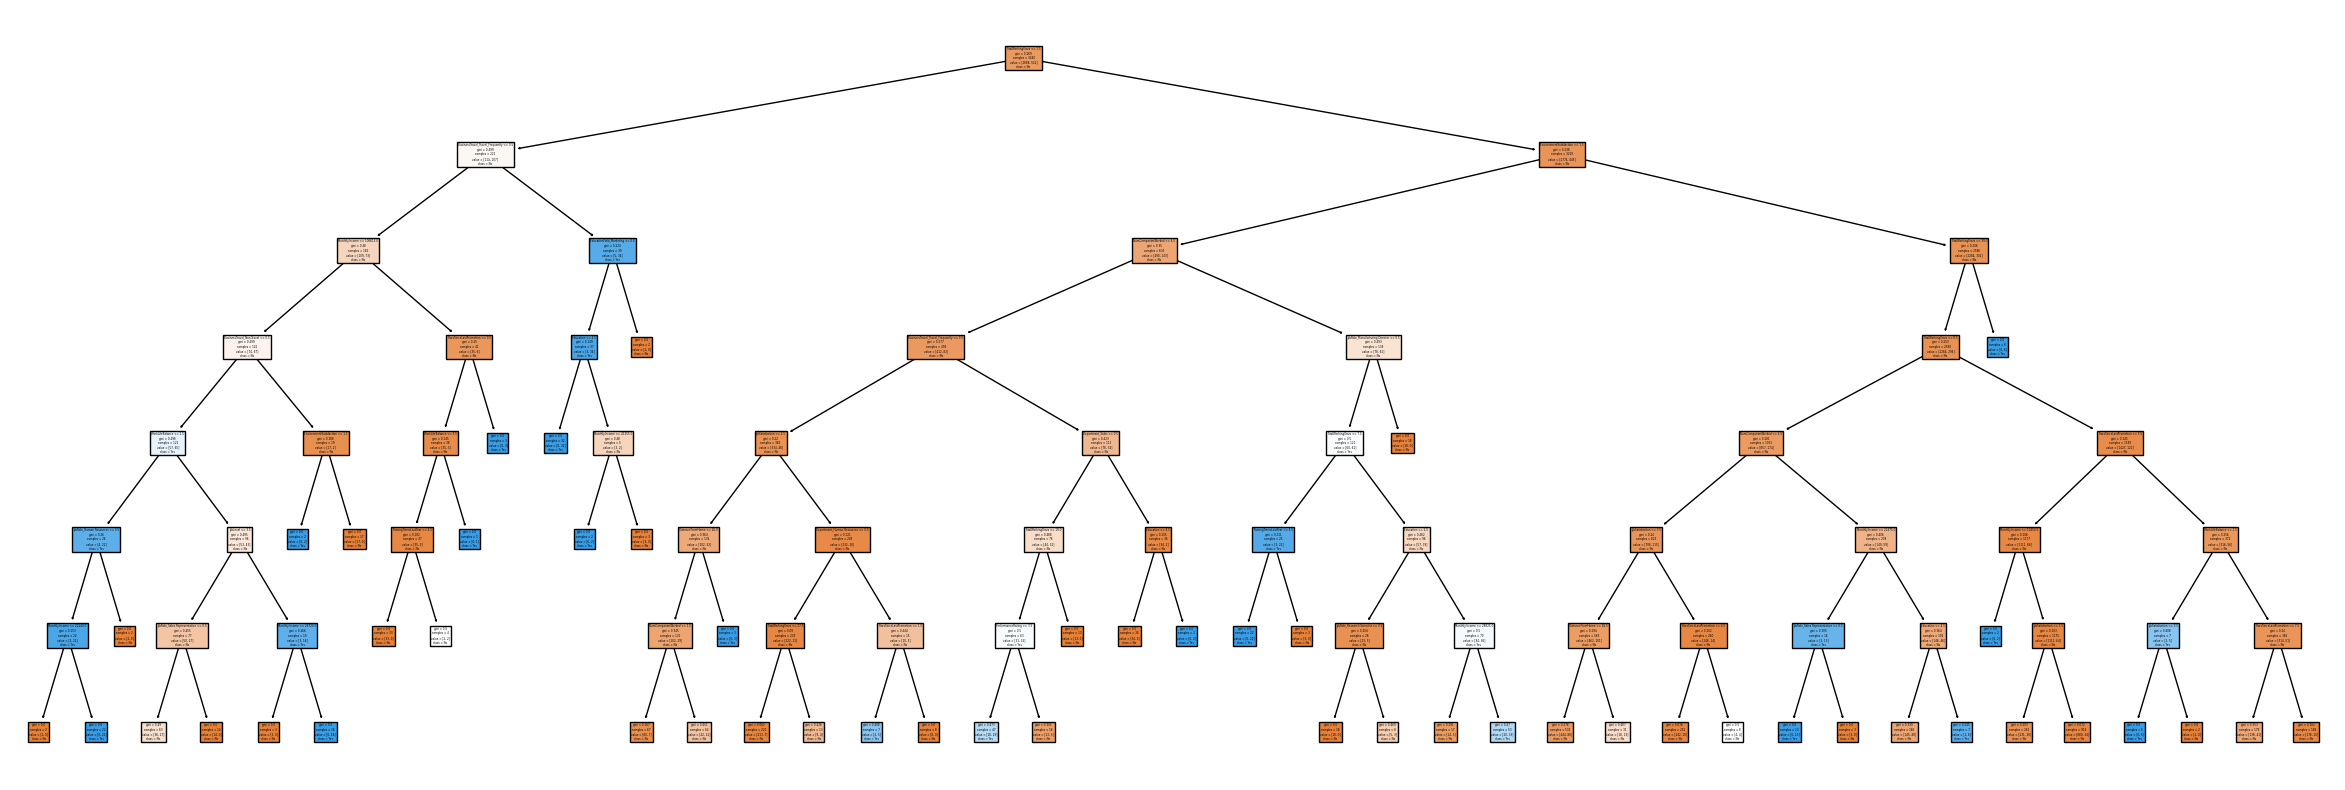

In [136]:
plt.figure(figsize=(30, 10))
tree.plot_tree(decision_tree, filled=True, feature_names=train_x.columns.tolist(), class_names=['No', 'Yes'])

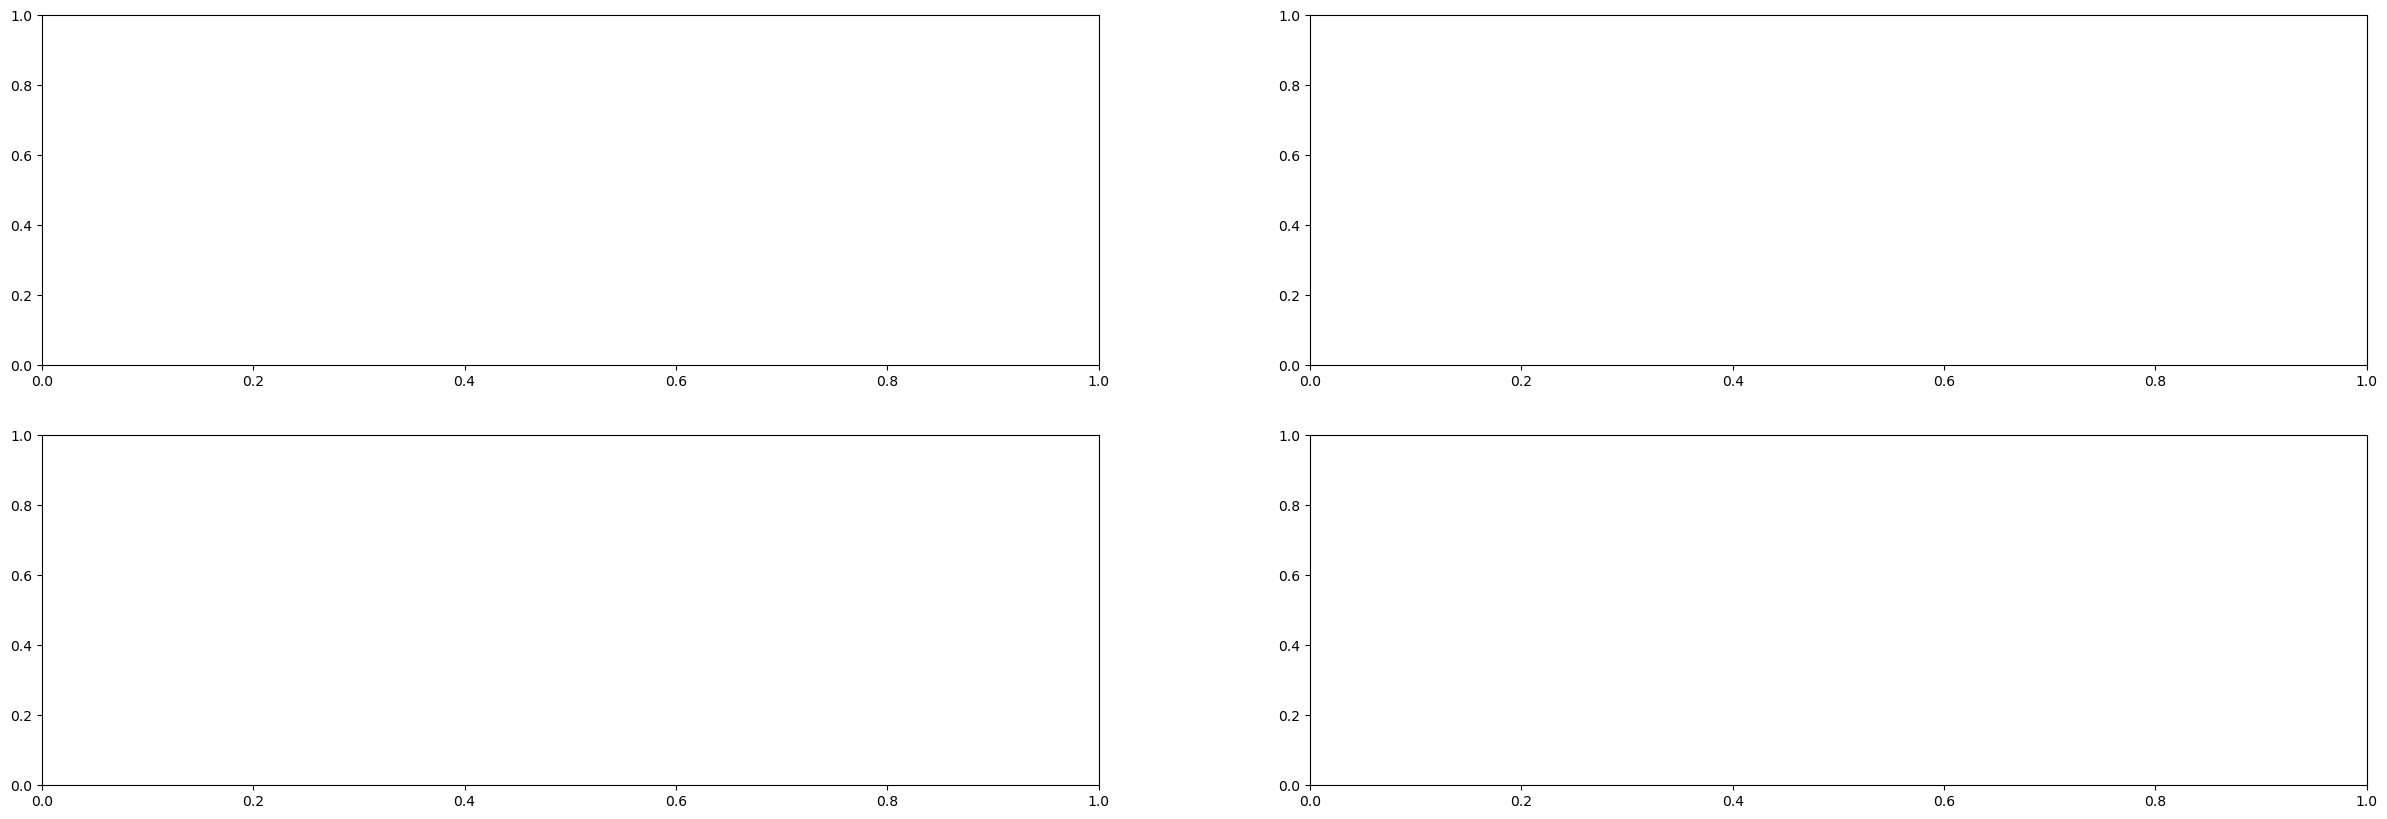

In [137]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(30, 10))
for i in range(4):
    to_graphviz(best_xgb_model, num_trees=i, ax=axes[i//2, i%2])
plt.subplots_adjust(wspace=0.2, hspace=0.2)

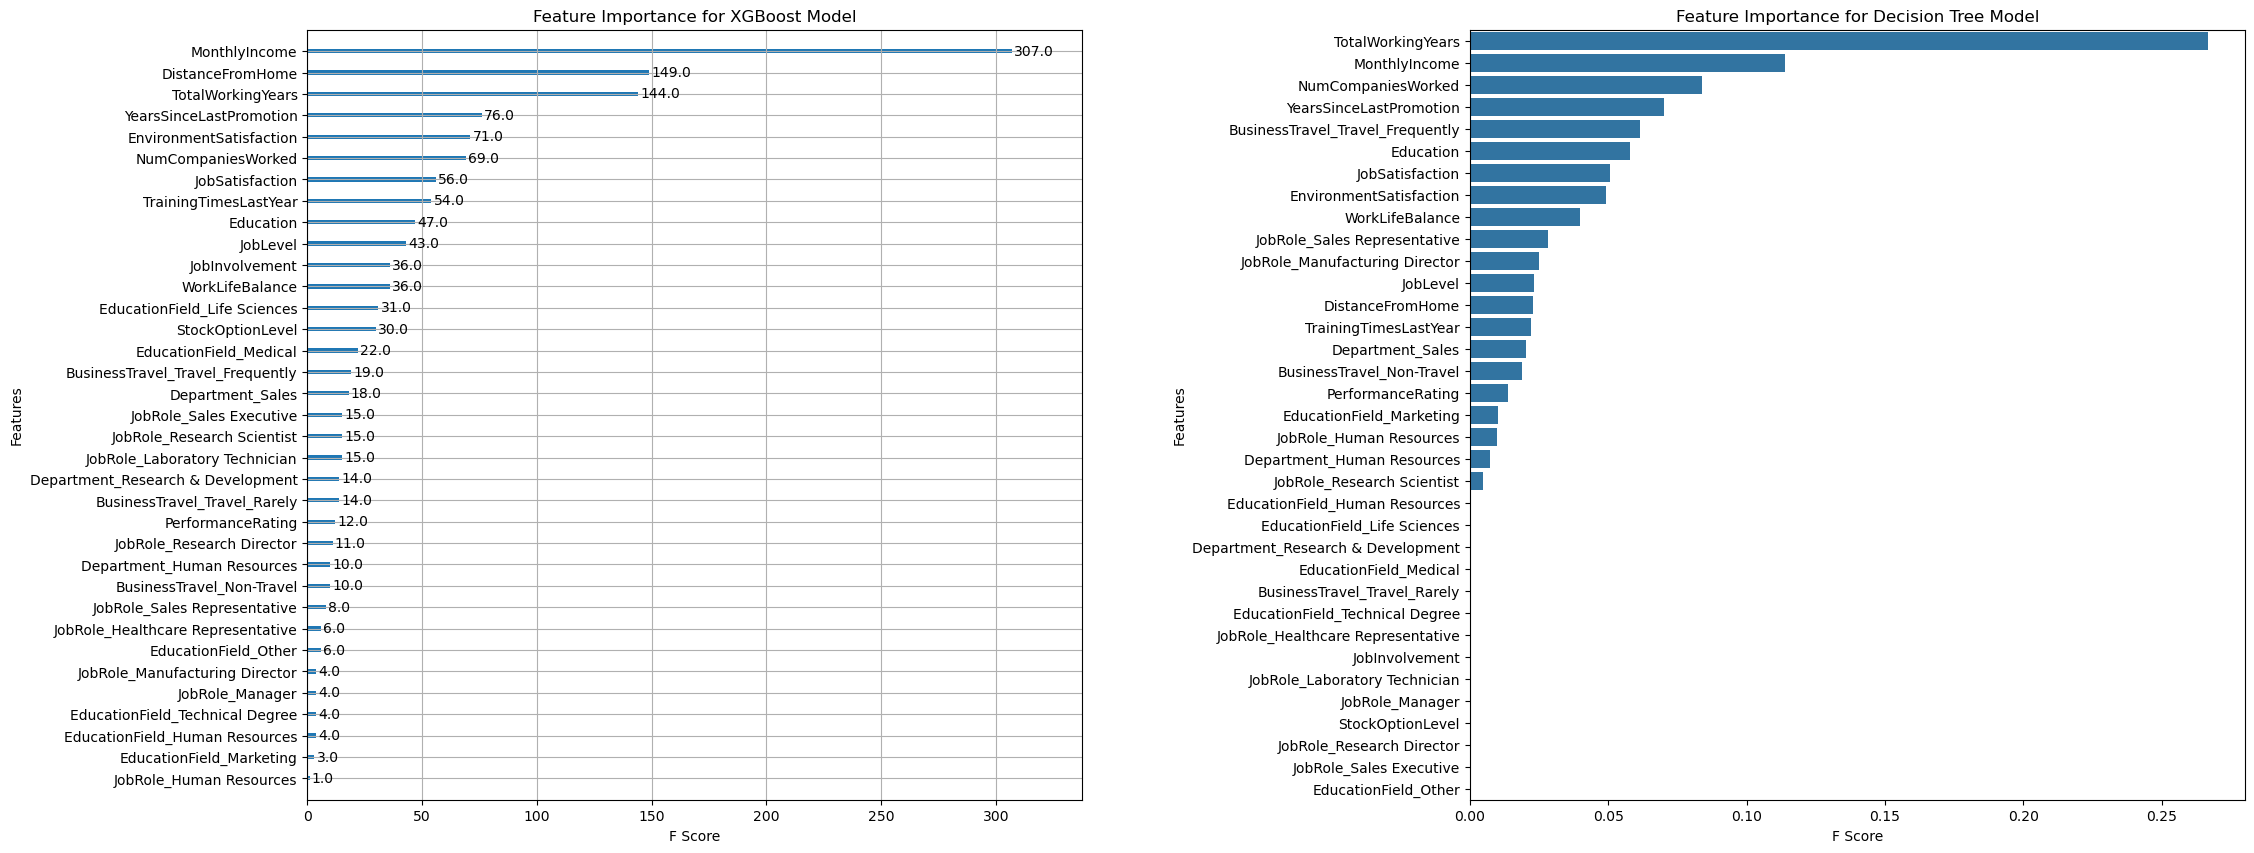

In [142]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(25, 10))
plot_importance(best_xgb_model, ax=ax1, importance_type='weight')
ax1.set_title('Feature Importance for XGBoost Model')
ax1.set_xlabel('F Score')
ax1.set_ylabel('Features')

importance = decision_tree.feature_importances_
df_importance = pd.DataFrame({'Feature': train_x.columns, 'Importance': importance})
df_importance = df_importance.sort_values('Importance', ascending=False)
sns.barplot(x='Importance', y='Feature', data=df_importance, ax=ax2)
ax2.set_title('Feature Importance for Decision Tree Model')
ax2.set_xlabel('F Score')
ax2.set_ylabel('Features')

plt.subplots_adjust(wspace=0.5)